In [ ]:
!pip install treeinterpreter
!pip install ggplot

In [ ]:
from treeinterpreter import treeinterpreter as ti
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_graphviz
import seaborn as sns
import scipy as sp
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from ggplot import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd

# От маленького деревца к большому лесу

На сегодняшний день те, кто хоть раз сталкивался с машинным обучением, наверняка слышали о решающих деревьях, их ансамблях и всевозможных модификациях, применяемых под различные задачи. Действительно, несмотря на то, что первые упоминания регресионных деревьев датируются еще 60-ми годами прошлого века, основное развитие деревьев решений в 80-90е годы, появление CART, ID3 и других подходов, заложило большой фундамент для огромного класса алгоритмов, в основе которых лежит древовидная структура. Одним из таких алгоритмов, получивших широкое распространение, является случайный лес, о котором и пойдет речь в этом туториале.

Одним из несомненных плюсов, которые выделяют у деревьев в целом, является их интерпретируемость. Взглянув на построенное дерево, вы с легкостью можете определить, по каким причинам было принято то или иное решение.  
Например, за 3 простых шага можно определить, испортился ли продукт в холодильнике.

<img src="img/tree.png" width="50%" height="50%">

Однако, когда речь заходит о случайном лесе, начинают возникать некоторые сложности, и связаны они в первую очередь с тем, что алгоритм представляет собой композицию таких деревьев, не говоря уже и о том, что каждое дерево может строится не на всей выборке и не со всеми признаками.  
В результет также легко пройтись по картинке и понять, почему ваш продукт протух, уже не получится. Несмотря на всю, казалось бы, "непроходимость" данного леса, определенную информацию, дающую представление о структуре вашего леса, из него все же можно получить.   

<img src="img/forest.png" width="50%" height="50%">

# Как устроены решающие деревья

Прежде чем переходить к самому сладкому, необходимо вспомнить, как прорастают такие деревья. Данная тема уже ни раз подробно разбиралась в различных статьях и курсах, в том числе курсе от ODS, поэтому напомним лишь основные вехи.  
Основным подходом для формирования каждого последующего разбиения является максимизация функционала: $${Q}=H({R_m})-\frac{|R_l|}{|R_m|}H(R_l)-\frac{|R_r|}{|R_m|}H(R_r)$$
где ${R_i}$ - объекты в i-ом поддереве, $ \frac{|R_i|}{|R_m|}$ - кол-во объектов, попавших в соответствующее поддерево, $H({R_i})$ - критерий информативности, характеризующий качество разбиения i-ого листа при $i \in \{R - правое\ поддерево\ ;L - левое\ поддерево; M - разбиваемый\ лист\}$  
В зависимости от задачи, которую предстоит решать вашим деревьям, критериями информативности $H(R)$ для выбора разбиения могут выступать:
* В задаче классификации:  $$Кросс\ энтропия :  S = -\sum_{k=1}^{K}p_i \log_2{p_i}$$ $$Неопределенность\ Джини : G = 1 - \sum\limits_{k=1}^{K} (p_k)^2$$
где p - доля k-ого класса в листе.
$$$$
* В задаче регрессии: $$Среднеквадратическая\ ошибка : {MSE}=\frac{1}{n}\sum_{k=1}^{K}(Y_i-\hat{Y_i})^2$$
где $Y_i$ - среднее значение целевой переменной в сформированном листе.

Чтобы не упустить ничего важного, рассмотрим небольшой пример, как строится дерево на примере задаче классификации и метрики Джини.  
Для демонстрации сгенериуем датасет, имитирующий полки магазина, где наша цель будет научиться отделять овощи от фруктов по их расположению на полке.  

<img src="img/shelf_fruits.png" width="40%" height="40%">

In [ ]:
X=np.arange(3)
X_df=np.array(np.meshgrid(X,X)).T.reshape(-3,2)
y_df=np.zeros(9).reshape(-1,1)
y_df[5]=1
y_df[8]=1

dt_clf=DecisionTreeClassifier()
dt_clf.fit(X_df,y_df)

export_graphviz(dt_clf, feature_names=['Номер на полке','Номер полки'], 
out_file='small_tree1.dot', filled=True)
!dot -Tpng 'C:\Users\Maksim.Ostroukhov\small_tree1.dot' -o 'small_tree.png'

In [ ]:
export_graphviz(dt_clf, feature_names=['Номер на полке','Номер полки'], 
out_file='C:\\Users\\Maksim.Ostroukhov\\small_tree1.dot', filled=True)
!dot -Tpng 'C:\Users\Maksim.Ostroukhov\small_tree1.dot' -o 'small_tree.png'

<img src="img/small_tree_ent.png">

Получившееся дерево всего за 2 разбиения идеально справилось со своей миссией. Теперь взглянем на то, какой признак сыграл наибольшую роль в решениии этой <s>непростой</s> задачи.  
Бегло просмотрев картинку, можно сделать вывод, что номер полки в данном случае является наиболее важным параметром. Но так ли велика разница между ним и номером продукта на полке? Для ответа на этот вопрос воспользуемся критерием, который используется в современной реализации sklearn для подсчета важности признаков и называется mean decrease impurity (MDI): $$MDI(X_m)=\sum_{n} \frac{|R_c|}{|R|} Q$$  
где $n$ - количество, нод, в которых используется выбранный признак $m$, $\frac{|R_c|}{|R|}$ - доля объектов от общего числа, достигших ноду $c$, $Q$ - функционал качества, который мы оптимизируем.  
Суть данного критерия сводится к сравнению, насколько тот или иной признак улучшил разделимость классов/повысил точность с учетом доли объектов, используемых при разбиениях по этому признаку. Разберем на конкретном примере, как же считается важность признаков на основе данной метрики. 

Поскольку на каждый признак приходится по одной ноде, то и в наша формула сведется к расчету функционала качества для одной ноды с поправкой на кол-во объектов в ней.  
Тогда $MDI$ для наших признаков: 
$$MDI(номер\ полки)=(0.346-0\cdot\frac{6}{9}-0.444\cdot\frac{3}{9})\cdot1\approx0.198$$ 
$$MDI(порядковый\ номер\ на\ полке)=(0.444-0\cdot\frac{1}{9}-0\cdot\frac{2}{9})\cdot\frac{3}{9}\approx0.148$$

Отмасштабируем полученные рез-ты и сравним с результатами, которые нам формирует sklearn:  
$$MDI(номер\ полки)\approx\frac{0.198}{0.198+0.148}\approx0.5722$$
$$MDI(порядковый\ номер\ на\ полке)\approx\frac{0.148}{0.198+0.148}\approx0.428$$

In [108]:
print(list(zip(['Порядковый номер на полке','номер полки'],dt_clf.feature_importances_)))

[('Порядковый номер на полке', 0.42857142857142855), ('номер полки', 0.5714285714285714)]


Бдительный читатель может сразу заметить, что результаты с учетом округления немного отличаются. Для получения максимально точных результатов предлагается повторно проделать эту же операцию с самостоятельным подсчетом неопределенности Джинни, поскольку для текущих расчетов использовались окгругленные значения, изображенные на графе. 

In [119]:
first_node_gini=1-(7/9)**2-(2/9)**2
second_node_gn=1-(1/3)**2-(2/3)**2

y_imp=first_node_gini-0*(6/9)-(second_node_gn)*(3/9)
x_imp=(second_node_gn-0*(1/9)-0*(2/9))*3/9

print('Важность расположения на полке: {0},\nВажность номера полки: {1}'.format(x_imp/(x_imp+y_imp),y_imp/(x_imp+y_imp)))

Важность расположения на полке: 0.42857142857142855,
Важность номера полки: 0.5714285714285714


Не так страшен "черт", не правда ли? Чтобы наконец обобщить данную формулу для случайного леса, который по сути является всего лишь композицией таких деревьев, нам необходимо просуммировать MDI по всем деревьям в получившемся лесе и взять среднее по всему лесу.

 $$MDI(X_m)=\frac{1}{t}\sum_{t}\sum_{n} \frac{|R_c|}{|R|} Q$$  

где t - кол-во деревьев в лесе.

Несколько вещей, которые стоит знать об этом критерии:
* Если в данных присутствуют скореллированные признаки, то при выборе параметров только один из этих признаков будет выбран в качестве предиката, и, как результат, получит высокий коэффициент MDI. Конечно, это не является проблемой, если мы занимаемся отбором признаков, например, для устранения эффекта переобучения. С другой стороны, с точки зрения интерпретации полученных результатов могут возникнуть некоторые сложности, поскольку не использованные в разбиениях признаки получат низкую оценку и скорее всего останутся за пределами нашего исследования
* Данный критерий отдает предпочтение признакам с большим количеством категорий. Подробнее об этом [тут](https://link.springer.com/article/10.1186%2F1471-2105-8-25 )

Конечно, MDI критерий не единственный в своем роде. Альтернативным подходом для измерения важности признака по доле наблюдений, охватываемых данным признаком, является mean decreased accuracy (MDA) aka permutation importance. В данном случае гипотеза состоит в том, что если признак не так важен, то перемешивание значений в соответствующей колонке слабо повлияет на точность алгоритма.  

<img src="https://media.giphy.com/media/1AIwsXQzH1Js6cxVBU/giphy.gif" width="30%" height="30%">

Для MDA характерны следующие черты:
* Вычисляется быстрее чем MDI
* Не требует bootstrap выборки при создании модели и устройчива к корреляции признаков
* На практике часто совпадает с MDI

Общее описание алгоритма:
1. Обучаем наш случайный лес на исходных данных 
2. Считаем интересующую нас метрику $S_b$ на наших данных для полученной модели
3. Для каждого признака $X_i$, где X - имеющаяся выборка, поочередно проделываем следущие шаги
    * Случайным образом перемешиваем данные внутри выбранного $i$-ого признака
    * Считаем метрику $S_i$ на получившемся наборе данных
    * Находим разницу $\Delta S_i$ между метриками $S_b$ на исходном наборе и $S_i$ на наборе с измененным признаком

В результате для каждой переменной мы получили $\Delta S$, где $|\Delta S|$ говорит нам о том, насколько изменение данного параметра влияет на точность получившегося алгоритма. Соответственно, те признаки, у которых это значение сравнительно мало можно отбросить, предполагая, что для конечного алгоритма они не так важны.

К сожалению, в отличие от R, в котором данный метод реализован в библиотеке randomForest, в sklearn такой опции нет. Но это не повод отчаиваться! Ниже представлена реализация такого алгоритма и сравнение результатов с MDI. В качестве набора данных будем использовать стандартный датасет цен на Бостонскую недвижимость и факторов, влияющих на эту цену. 

$Расчет\ MDA:$

In [373]:
def score(x1,x2):
    return metrics.mean_squared_error(x1,x2)
# defining feature importance function based on above logic
def feat_imp(m, x, y, small_good = True): 
    score_list = {} 
    score_list['original'] = score(m.predict(x.values), y) 
    imp = {} 
    for i in range(len(x.columns)): 
        rand_idx = np.random.permutation(len(x)) # randomization
        new_coli = x.values[rand_idx, i] 
        new_x = x.copy()            
        new_x[x.columns[i]] = new_coli 
        score_list[x.columns[i]] = score(m.predict(new_x.values), y) 
        imp[x.columns[i]] = score_list['original'] - score_list[x.columns[i]] # comparison with benchmark
    if small_good: 
         return sorted(imp.items(), key=lambda x: x[1]) 
    else: 
        return sorted(imp.items(), key=lambda x: x[1], reverse=True)

def mda_boston(rf):
    boston = load_boston()
    X = boston["data"]
    Y = boston["target"]
    names = boston["feature_names"]
    X=pd.DataFrame(X,columns=names)
    rf.fit(X, Y)
    return pd.DataFrame(feat_imp(rf,X,Y),columns=['Признак','Важность'])

In [374]:
rf=RandomForestRegressor(random_state=256)
var_importance=mda_boston(rf)
var_importance

,Признак,Важность
0,LSTAT,-52.987223
1,RM,-51.031723
2,DIS,-6.632130
3,CRIM,-6.110963
4,NOX,-4.333413
5,PTRATIO,-2.256260
6,AGE,-1.347716
7,TAX,-1.302830
8,INDUS,-1.001670
9,B,-0.887314


$Расчет\ MDI:$

In [376]:
sorted(list(zip(boston["feature_names"],rf.feature_importances_)),reverse=True,key=lambda x:x[1])

[('RM', 0.4645898313429839),
 ('LSTAT', 0.35182346004313203),
 ('DIS', 0.061251328408256145),
 ('CRIM', 0.03977662113950492),
 ('NOX', 0.02061378656223358),
 ('PTRATIO', 0.01932330429116442),
 ('AGE', 0.011220816883363013),
 ('TAX', 0.010690452048413087),
 ('B', 0.008943853177943635),
 ('INDUS', 0.007581362480570153),
 ('RAD', 0.0030993545872310966),
 ('ZN', 0.000652335297086997),
 ('CHAS', 0.00043349373811705003)]

Как и в случае с более классическим подходом MDI, не смотря на разные подходы, метрики почти совпали. В данной ситуации мы наверняка можем сказать, что признак "Среднее количество комнат на один жилой дом"(RM) и "процент низжих слоев населения от общей количества"(LSTAT) являются наиболее важными, и выкидывать их из признакового описания не стоит.

# График частичной зависимости

Допустим, что в нашей задаче нам удалось выделить признак, важность которого сомнений не вызывает. Естественным желанием в таком случае будет посмотреть, а как же зависит наше целевое значение от выбранного параметра. Хорошей аналогией в данном случае будут коэффициенты линейной регресии, посмотрев на котоорые, можно сказать на сколько изменится значение $Y$ при изменении признака $X$ на 1.   
Первое, что приходит в голову в такой ситуации - это построить диаграмму рассеяния и надеяться, что там мы найдем ответы на все интересующие нас вопросы.

[Text(0,0.5,'SalePrice'), Text(0.5,0,'RM')]

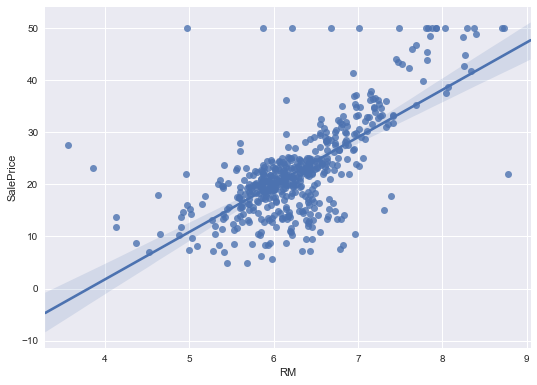

In [361]:
sns.set(rc={'figure.figsize':(8.7,6.27)})
ax = sns.regplot(X.iloc[:,5],Y)
ax.set(xlabel='RM', ylabel='SalePrice')

Казалось бы, какие тут могут возникнуть проблемы? Основным недостатком такого подхода является возможное наличие дополнительных зависимостей, которых такой график исключить не может, а также отсутствие возможности определить величину изменения целевой переменной при увеличении/уменьшении признака.  

С другой стороны у нас есть важность признаков, отражающая влияние каждого на целевую переменную, и которую мы теперь умеем выводить аж 2мя способами! Но и тут мы упираемся в невозможность интерпретации абсолютного значения коэффициентов. И тут на первое место выходит другой подход - Partial Dependence Plot (PDP), идея которого заключается в изолировании влияния конкретной переменной на объясняемый показатель и попытка приблизить нас к ответу на вопрос "А что будет, если мы увеличим признак на 1?".

Алгоритм построения PDP:
1. Обучим "лесную" модель на наших исходных признаках $X$
2. Выберем признак $X_i$, значения которого нам бы хотелось интерпертировать (чтобы избежать случаный флуктуаций, рекомендуется опираться на важность признаков и выбирать более-менее "сильные" признаки)
3. Выведем все уникальные отсортированные по возрастанию значения $\{X_i\}$, которые может принимать данный признак $X_i$
4. Подставляем вместо исходных значений признака первое уникальное значение $X_{ij}$
5. Используя нашу модель, делаем предсказание на новом наборе данных и берем среднее от полученных значений. Назовем рассчитанное среднее - базовым значением. Его мы будем использовать далее для подсчета относительного изменения.  
4. Для каждого следующего уникального значения $X_{ij}, где j\neq0$ из выбранной колонки:
    *  Заменяем всю колонку на выбранное значение.
    *  Снова делаем предсказание на изменненном наборе и, взяв среднее, считаем разницу от вычисленного ранее базового значения.
5. Результатом должен стать график, у которого на оси X отложены уникальные значения признака, а по оси Y изменения относительно базогового значения, которое на графике обозначено 0.

Не будем терять ни минуты и, используя описанный выше алгоритм, построим график для признака "Среднее количество комнат на один жилой дом"(RM), в важности которого мы почти не сомневаемся.

In [362]:
def feat_pdp(m, x, y, feature_name): 
    unique_values = sorted(x[feature_name].unique())
    new_x=x.copy()
    new_x[feature_name]=unique_values[0]
    base_value=np.mean(m.predict(new_x.values))
    score=[]
    score.append(0)
    for i in range(len(unique_values)-1):             
        new_x[feature_name]=unique_values[i+1]
        score.append(np.mean(m.predict(new_x.values)-base_value))
    return score,unique_values

def pdp_boston():
    boston = load_boston()
    X = boston["data"]
    Y = boston["target"]
    names = boston["feature_names"]
    X=pd.DataFrame(X,columns=names)
    rf = RandomForestRegressor(random_state=256)
    rf.fit(X, Y)
    return feat_pdp(rf,X,Y,'RM')

In [ ]:
scores,unique_values=pdp_boston()
df_pdp=pd.DataFrame({
    'RM': unique_values,
    'SalePrice': scores
})
#последовательно отрисовать 2 графика
ggplot(pd.concat([X,pd.DataFrame(Y,columns=['SalePrice'])],axis=1), aes('RM', 'SalePrice'))+stat_smooth(se=True, method='loess',span=0.2)+ylab(element_text(size=20, text='SalePrice')) +\
xlab(element_text(size=25, text='Line Plot'))

ggplot(df_pdp, aes('RM', 'SalePrice'))+stat_smooth(se=True, method='loess',span=0.2)+ylab(element_text(size=20, text='SalePrice')) +\
xlab(element_text(size=20, text='RM'))

<img src="img/pdp_plot.Jpg">

Чтобы убедиться в том, что PDP действительно не обманывает нас, ниже приведена таблица, в которой несколько раз меняется значение RM и делается предсказание при неизменных остальных признаках. Результат говорит нам о том, что LinePlot действительно не изолирует влияние других переменных, поскольку, ориентируясь на него, мы бы прогнозировали значительно меньший результат при изменении значения RM с 3.863 до 4.8. Во втором случае значение количества квартир подросло до 7 и это дало нам прирост в $\approx10$ ед в SalePrice, что прекрасно отражено на графике частичной зависимости. 

<img src="img/res_pdp.Jpg">

Как вы можете видеть, PDP, в отличие от обычного линейного графика, устраняет влияние сторонних факторов, что хорошо видно при небольшом количестве квартир. Более интуитивной визуализация получается, если использовать при построении категориальные признаки. Больше крутых примеров в [репозитории курса fast.ai](https://github.com/fastai/fastai/tree/7016feaf39583977ff9f70972e5a3232c8bd4447/courses/ml1)

# Пути принятия решений

Часто случаются ситуации, когда не столько интересует важность признаков в целом, сколько их вклад в формирование предсказания для конкретных наблюдений. Прежде чем лезть в наш дремучий лес,снова сделаем небольшой шаг назад и рассмотрим на примере одного дерева, как формируется конкретное предсказание.  
Для этих целей нам понадобится удобная библиотека [treeinterpreter](https://pypi.org/project/treeinterpreter/), которая легким движением <s>топора</s> разделяет деревья на пеньки и позволяет заглянуть внутрь.

<img src="img/treeinterp.png"  width="70%" height="70%">

Для начала взглянем на построенное для этой задачи решающее дерево. Сразу сделаем маленькое уточнение, что для удобства в данном случае мы намеренно ограничили максимальную глубину дерева до 3. 

In [367]:
dt_clf=DecisionTreeRegressor(random_state=256,max_depth=3)
dt_clf.fit(X,Y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=256, splitter='best')

<img src="img/small_tree_path.png">

Также, пользуясь классическим определением прогнозной функции, данным Jerome Friedman в книге The Elements of Statistical Learning, $f(x) = \sum_{m=1}^{M} c_m I(x\in R_m)$, где $c_m$ - это константое значение предсказание в листе, $I(x\in R_m)$ - индикаторная функция, показывающая принадлежность объекта к одному подмножеств $R_m$, образованных разбиением в листе, M - количество листьев в дереве, введем несколько дополнительных понятий:
* Путь(Path)  - набор листьев, в который попадает наше наблюдение 
* Вклад(Contribution) - вклад признака, рассчитываемый, как разница между константным значением $c_m$ в текущем и образованном листах

Перепишем прогнозное функцию на $f_{path}(x) = bias+\sum_{k=1}^{K} contrib_k$, где K -признаки, участвующие в Path, $contrib_k$ - вклад $k$-ого признака в предсказание, bias - среднее значение целевой переменной на всем наборе данных (в корневом листе), вклад в который и вносят наши признаки 

Рассмотрим это на примере.  
Пусть имеем наблюдение со следующим признаковым описанием:

<img src="img/test_treeint.JPG">

Воспользуемся новой терминологией, тогда:

<img src="img/bias_contr.JpG">

Как мы видим, предсказание действительно складывается из смещения и суммарного вклада каждого признака в изменение целевой переменной. Вооружившись полученным знанием, воспользуемся упомянутой библиотекой treeinterpreter и посмотрим на нее в действии. 

In [229]:
prediction, bias, contributions = ti.predict(dt_clf, X.iloc[367].values.reshape(1,-1))
print("Bias: {0}\nContributions:\n{1}\nPrediction:{2}".format(bias[0], '\n'.join(map(str,list(zip(names,contributions[0])))),prediction[0]))

Bias: 22.532806324110698
Contributions:
('CRIM', 0.0)
('ZN', 0.0)
('INDUS', 0.0)
('CHAS', 0.0)
('NOX', 0.0)
('RM', -2.599085393878145)
('AGE', 0.0)
('DIS', -0.4446039215686248)
('RAD', 0.0)
('TAX', 0.0)
('PTRATIO', 0.0)
('B', 0.0)
('LSTAT', 3.4160829913360757)
Prediction:22.905200000000004


Вопросов к тому, что делает библиотека после этого блока кода, уже возникать не должно, но на всякий случай еще раз уточним, что метод predict в данном случае возвращает 3 компоненты:
* Prediction - предсказанный моделью результат 
* Bias - смещение, среднее значение target'a на всем наборе данных
* Contribution - вклад каждого признака в построение предсказания  

Убедимся на всякий случай, что тут нет никакого обмана, и проверим выполнения равенства $prediction = bias+\sum_{k=1}^{K}$:

In [236]:
print(np.sum(contributions)+bias,prediction)

[22.9052] [22.9052]


Отобразим вклады признаков, отсортировав их модули по убыванию: 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

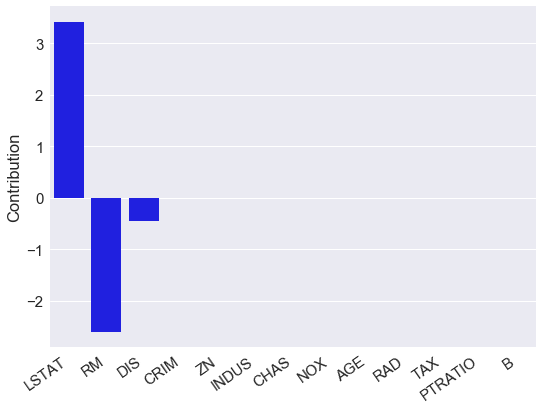

In [198]:
sns.set(rc={'figure.figsize':(8.7,6.27)},font_scale=1.5)
ax =sns.barplot(x=names,y=contributions[0],order=[x[0] for x in sorted(list(zip(names,contributions[0])),reverse=True,key=lambda x: np.abs(x[1]))],color='blue',orient='v')
ax.set(ylabel='Contribution')
plt.xticks(fontsize=15,rotation=35, ha='right')

Для нашего наблюдения наибольший вклад был получен благодаря LSTAT (процент населения, отнесенного к низшему классу), что с одной стороны говорит нам о важности признака для используемого набора параметров и с другой - немного настораживает, поскольку в предыдущих пунктах мы наблюдали явное доминирование признака RM над остальными. Стоит также взглянуть на то, как в целом влияет данный признак на целевую переменную.

Text(0.5,0,'LSTAT')

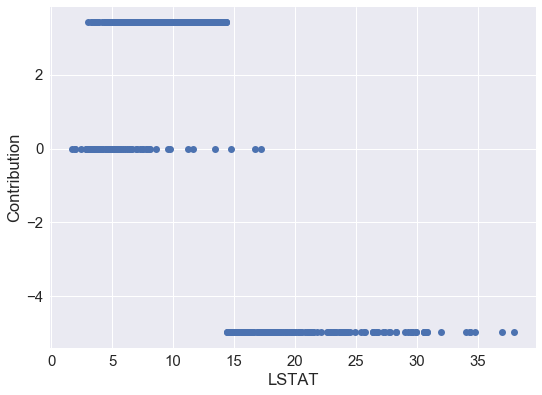

In [228]:
prediction, bias, contributions = ti.predict(dt_clf, X)
plt.plot(X.iloc[:,-1].values,contributions[:,-1],'o')
plt.ylabel('Contribution')
plt.xlabel('LSTAT')

Из-за того, что пока мы работаем только с одним деревом, общий паттерн на данном графике разглядеть довольно непросто. Акцент можно сделать лишь на отрицательном тренде при увеличении показателя, что вполне логично, поскольку районы с большим кол-вом бедного населения явно не уличивают стоимость жилья. 

Дальше - больше! Мощь библиотеки раскрывается при использовании ее в комбинации со случайным лесом, реализованном именно в пакете sklearn, поскольку его API позволяет получить ссылку на пути решения для отдельных деревьев в лесе. Воспользуемся моделью, которую мы уже обучили ранее, и посмотрим на вклад признаков в предсказание. С точки зрения формулы разложения предсказания процесс совсем не усложнился. Интуитивно понятно, что вместо одного дерева мы имеем теперь композицию, а значит расширение для случайного леса будет выглядеть как среднее от суммы вкладов признаков в каждом дереве.
$$f_{path}(x) = \frac{1}{t}\sum_{t}bias+\sum_{k=1}^{K}(\frac{1}{t}\sum_{t}contrib_k)$$
где t-кол-во деревьев в лесе.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

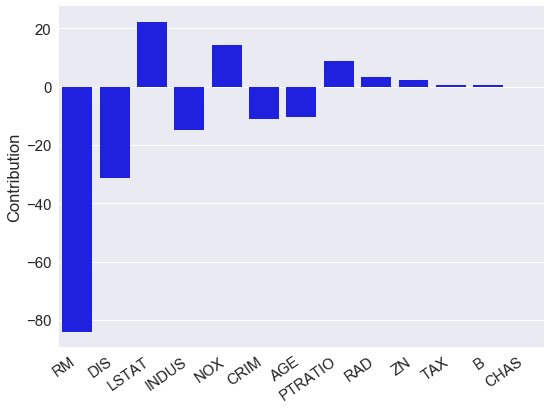

In [369]:
prediction, bias, contributions = ti.predict(rf, X)
sns.set(rc={'figure.figsize':(8.7,6.27)},font_scale=1.5)
ax =sns.barplot(x=names,y=contributions.sum(axis=0),order=[x[0] for x in sorted(list(zip(names,contributions.sum(axis=0))),reverse=True,key=lambda x: np.abs(x[1]))],color='blue',orient='v')
ax.set(ylabel='Contribution')
plt.xticks(fontsize=15,rotation=35, ha='right')

В отличие от нашего неглубокого дерева, в лесе все встало на свои места, и RM признак начал давать наибольший вклад в цену за Бостонское жилье, но все же не помешает взглянуть, как теперь распределен вклад признака LSTAT в зависимости от предсказанной цены.

Text(0.5,0,'LSTAT')

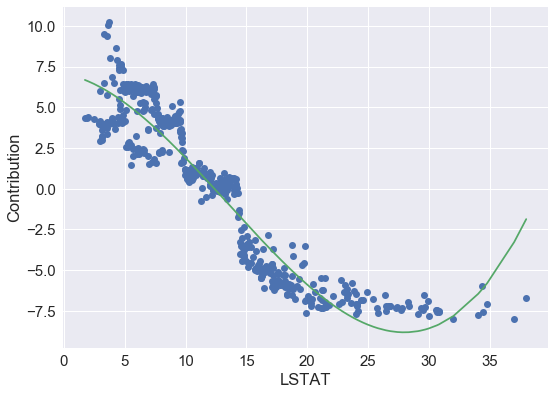

In [371]:
sns.set(rc={'figure.figsize':(8.7,6.27)},font_scale=1.5)
plt.plot(X.iloc[:,-1].values,contributions[:,-1],'o')
z = np.poly1d(np.polyfit(X.iloc[:,-1].values, contributions[:,-1], 3))
z_poly_x=[i[0] for i in sorted(list(zip(X.iloc[:,-1],z(X.iloc[:,-1].values))))]
z_poly_y=[i[1] for i in sorted(list(zip(X.iloc[:,-1],z(X.iloc[:,-1].values))))]
plt.plot(z_poly_x,z_poly_y)
plt.ylabel('Contribution')
plt.xlabel('LSTAT')

Как мы и говорили, в случайном лесе мы наконец можем наблюдать подобие монотонной зависимости, которая достигается во многом благодаря изменчивости предсказаний из-за большого количества деревьев.  
<i>Промежуточный итог: если вам мучает вопрос, а что именно повлияло на ваше предсказанное значение, библиотека treeinterpeter послужит вашим лекарством от всех болезней.</i>

# Доверительные интервалы

В предыдущих частях мы много говорили о том, как формируется предсказание модели, какие факторы влияют на прогнозную силу в целом и на пресказание для отдельных наблюдений. Но до текущего момента мы воспринимали спрогнозированное значение, как максимально точную оценку целевого признака.  
Возможно, для внутреннего использования такой подход и подойдет, но если речь заходит о бизнес метриках, то тут вступают в силу совершенно другие требования, и заказчику, как правило, хочется видеть не только точечную оценку значения, но и насколько сильно он может доверять такой оценке или другими словами, насколько велик разброс для предсказанного значения.  
Представим себе типичную задачу кредитного скоринга, когда банку для предоставления какой-либо услуги необходимо оценить величину риска того, что клиент окажется неблагонадежным, и посчитать возможные потери по услуге. Модель, которая, выражаясь в терминах bias-variance, имеет высокий разброс, должна в первую очередь выдавать интервальные оценки таких потерь, чтобы конечный пользователь, не смотря на условно высокую точность алгоритма, мог оценить, насколько велик разброс оценки используемой модели. 

<img src="img/garfield-1.JpG">

В отличие от линейных моделей, зарекомендовавших себя в том же банковском секторе в основном благодаря интерпретируемости и возможности построения интервальной оценки, в случайном лесе с разбросом полученной оценки все не так однозначно.  
Как мы помним, случайный лес состоит из некоторого количества базовых моделей, каждое из которых выдает свой прогноз. Основной идеей в данном случае является построение доверительных интервалов, анализируя предсказания каждого дерева в отдельности, предполагая, что наш алгоритм более уверен в тех местах, где спрогнозированные значения не подлежат такой сильной флуктуации.  

Алгоритм для расчета доверительных интервалов:

In [349]:
def make_ci(clf,pred_value,true_value,ci):
    tree_preds=np.vstack([tree.predict(pred_value) for tree in clf.estimators_])
    upper=np.percentile(tree_preds,50+ci/2,axis=0)
    lower=np.percentile(tree_preds,(100-ci)/2,axis=0)
    y_pred=clf.predict(pred_value)
    y_true=true_value
    error=y_true-y_pred
    deviation=(upper-lower)/y_pred
    return pd.DataFrame({'Deviation':deviation,'Error':error,'Higher Bound':upper,'Lower Bound':lower,'Predicted value':y_pred,'True value':y_true,},columns=['True value','Predicted value','Error','Lower Bound','Higher Bound','Deviation'])

In [372]:
make_ci(rf,X[364:367],Y[364:367],95)

,True value,Predicted value,Error,Lower Bound,Higher Bound,Deviation
0,21.9,30.61,-8.71,21.90,50.0,0.918001
1,27.5,25.22,2.28,13.79,27.5,0.543616
2,21.9,21.17,0.73,19.90,21.9,0.094473


Построив доверительные интеварлы, мы видим, насколько сильно может расти разброс значения от дерева к дереву. В данном случае полученные отклонения говорят нам о том, что наша модель наиболее уверенно определяет наблюдение с индексом 2, интервальное значение которого колеблется в пределах 5% от предсказанного значения   

<i>Заключение: в этом небольшом обзоре мы убедились, что случайный лес совсем незаслуженно часто называют black-box алгоритмом, познакомились с различными подходами к интерпретации деревянных моделей и в следующий раз, когда нас попросят воспользоваться каким-нибудь линейным алгоритмом, аргументируя это его интерпретируемостью, у нас будет, что возразить!</i>

Полезные ссылки:
* Подходы к интерпретации случайного леса (те же грабли, только сбоку) https://towardsdatascience.com/intuitive-interpretation-of-random-forest-2238687cae45 
* Немного об интепретации в задаче классификации http://engineering.pivotal.io/post/interpreting-decision-trees-and-random-forests/
* Интересные визуализации по интерпретации леса от fast.ai https://github.com/fastai/fastai/tree/7016feaf39583977ff9f70972e5a3232c8bd4447/courses/ml1
